<a href="https://colab.research.google.com/github/sushelan/computationalphysicsprojects/blob/main/SushanthE_MachineLearningGalaxies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Galaxies

* **Author:** Sushanth Elangovan

* **Date:** 10/15/2025

* **Time spent on this assignment:**

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import  jax
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import pickle
import datetime;datetime.datetime.now()
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','FuncAnimation',
                       'HTML','itertools','pickle','testFunc','jnp','jax','jit']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

## you can set cpu to false if you want to use gpu or tpu
cpu=True
if cpu:
    jax.config.update('jax_platform_name', 'cpu')
#    jax.config.update("jax_enable_x64", True)
else:
    pass




## Exercise 1: Machine Learning on Galaxies

* **List of collaborators:**

* **References you used in developing your code:**

In this assignment, we are going to learn how to automatically classify galaxies using a deep neural network. Our goal will be to take a picture of a galaxy and decide which category it falls into (disc, round, cigar shape, etc).

We are going to get the pictures of our galaxies from the Sloan Digital Sky Survey and the labels from the Galaxy Zoo (where the public hand-categorizes the galaxies).  We will then write and train a neural network to do this classification. Our goal is to be at least 66% accuracy (one can do much better but it requires more work then is reasonable for this assignment).

Let's start by reading in the data. Run the following command to download a copy of the data we'll need

In [ ]:
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz

--2025-10-16 21:46:08--  https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84647509 (81M) [application/x-gzip]
Saving to: ‘dataG.pkl.gz.1’

dataG.pkl.gz.1      100%[===================>]  80.73M  18.4MB/s    in 4.2s    

2025-10-16 21:46:12 (19.3 MB/s) - ‘dataG.pkl.gz.1’ saved [84647509/84647509]



Now we'll unpack it to the format we need

In [ ]:
%%time
import gzip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(gzip.open("dataG.pkl.gz",'rb'))

CPU times: user 1.87 s, sys: 679 ms, total: 2.55 s
Wall time: 3.86 s


here's what you now have:
* `train_images_raw` - images in the training set, shape: (17457, 69, 69, 1)
* `train_labels`     - labels that explain the image classification for the training set
* `test_images_raw`  - images for the test set, shape: (1940,69,69,1)
* `test_labels`      - labels that explain the image classification for the test set

### A Note on the data

The original data has 3 channels - g,r,i bands - while this dataset has only 1 (g). This set also only includes a subset of labels.

You are welcome to do this assignment with the full channel set and see how well it does; you'll need to download the full data we've provided:
```python
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
!unzip data.pkl.zip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(open("data.pkl",'rb'))
```

and then change the reshape commands below. Feel free to reach out to us for help.

### a. Galaxies

Let's now examine this data a bit.  We are first going to look at the training data.  The training data is what you are going to use to teach your neural network.  The test data is to check how good we are doing after (possibly during) training.  We won't use it to train, though (this is to avoid overfitting; we want our neural network to learn how to classify galaxies but not memorize everything in the training set).

We will start by plotting some of the galaxy images that we have loaded.  Do `plt.matshow(train_images_raw[0,:,:,0])` (This last `:,:,0]` is because there are three layers to each of these galaxies and we just want to see the first layer. We've actually only included this first layer for you to save space, but if you want to use the full data this is necessary)

The `g` band is the grayscale image. To get it to display as such, instead of using false color, you can try using `cmap='gray'` as an argument to `matshow`

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

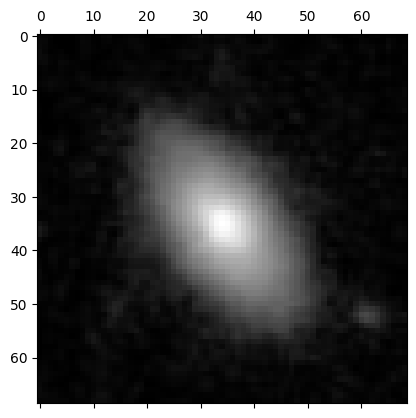

In [ ]:
#plot me here!
plt.figure()

plt.matshow(train_images_raw[0,:,:,0], cmap='gray',fignum=0)
plt.show()




<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

You should see a galaxy.  Now, let's see what this galaxy should be classified as.  Go ahead and print out `train_labels[0]`.


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
## print out the label
print(train_labels[0])

[0. 0. 1. 0. 0.]


<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

The galaxy dataset labels are given as follows. To make the exercise a little more simple, we have reduced the dataset to galaxies that are only classified as 5 of the types listed below.


Galaxy10 dataset (25753 images)
  * Class 0 (3461 images): Disk, Face-on, No Spiral: `[1,0,0,0,0]`
  * Class 1 (6997 images): Smooth, Completely round: `[0,1,0,0,0]`
  * Class 2 (6292 images): Smooth, in-between round: `[0,0,1,0,0]`
  * Class 3 (394 images): Smooth, Cigar shaped: skipped
  * Class 4 (3060 images): Disk, Edge-on, Rounded Bulge: `[0,0,0,1,0]`
  * Class 5 (17 images): Disk, Edge-on, Boxy Bulge: skipped
  * Class 6 (1089 images): Disk, Edge-on, No Bulge: skipped
  * Class 7 (1932 images): Disk, Face-on, Tight Spiral: `[0,0,0,0,1]`
  * Class 8 (1466 images): Disk, Face-on, Medium Spiral
  * Class 9 (1045 images): Disk, Face-on, Loose Spiral

![Galaxy10 dataset](https://astronn.readthedocs.io/en/v1.0.1/_images/galaxy10_example.png)

Let's instead display the image and label for image 98. We see that instead this is a disk galaxy (*this might depend on the randomness used in splitting up the training set so we need to check again when we re-pickle*)

[1. 0. 0. 0. 0.]


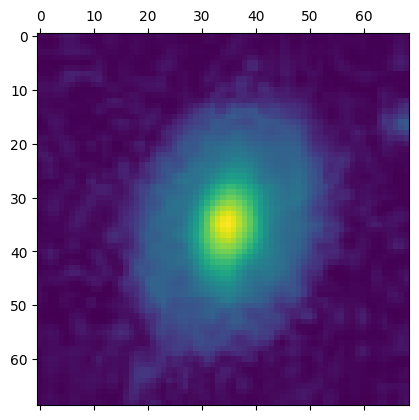

In [ ]:
plt.matshow(train_images_raw[98,:,:,0])
print(train_labels[98])

Let's check the shape of our data.  Go ahead and print out `train_images_raw.shape`

In [ ]:
print(train_images_raw.shape)

(17457, 69, 69, 1)


We have 17457 images.  Each image is a $69 \times 69 \times 1$ image.  We are going to give these pictures as inputs to our neural network.  It will be easier to give them a big $69 \times 69 \times 1 = 4761$ vector then a tensor like this.  Therefore, we should go ahead and reshape our data.  To do this, we can do `train_images=train_images_raw.reshape(len(train_images_raw),69*69*1)`  (Do the same thing for our `test_images_raw data`).  **You also need to normalize the image data so it's between 0 and 1.  To do that divide all your vectors by 256**

In [ ]:
train_images = train_images_raw.reshape(train_images_raw.shape[0],69*69*1)/256.
test_images  = test_images_raw.reshape(test_images_raw.shape[0],69*69*1)/256.


We will work with these reshaped vectors for most the rest of this assignment.




### b. Neural Network

---
#### <span style="color:red">Warning: Use ```jnp```!</span>
Notice that at the top of the file, we have imported ```jax.numpy as jnp``` alongside regular ```numpy as np```. To proceed with this assignment, you now need to start using ```jnp``` instead of ```np```. It's a drop-in replacement for all functions (```sum```, ```log```, etc.) that you'll normally use in numpy but is required for the fancy gradient calculations necessary for training your net.

---

Our next step is to write a neural network.   A neural network might sound complicated but it's actually really simple.  All our neural network does is take the input vector (our reshaped image) to an output vector (of size 5 because we have five different ways to classify a galaxy).  

The equation for how to do this is
 $v_{out} = 1.0/(1+\exp(-(W_2 \textrm{tanh}(W_1 v_{in} + b_1) +b_2))$
where
* W1 is a size d x 4761 matrix
* W2 is a size 5 x d matrix
* b1 is a size d  matrix
* b2 is a size 5  matrix

The last term: $1/(1+e^{-x})$ ensures that all the numbers in $v_{out}$ are between 0 and 1.


Implement a function
```python
def net(p,imageVector):
   a1 = p.W1@imageVector
   # other computations
   # return output
```
where `p` is a NamedTuple that contains these parameters and imageVector is one of our reshaped images.

You can define and initialize the NamedTuple as follows (keep in mind that you may need to change this):
```
from typing import NamedTuple

class Params(NamedTuple):
    W1: jnp.ndarray  # d x 4761
    b1: jnp.ndarray
    W2: jnp.ndarray
    b2: jnp.ndarray

d = 10
key = jax.random.PRNGKey(12423)
p = Params(W1 = 0.1*jax.random.normal(key, (d, 69*69*1)),
           b1 = jnp.zeros((d,)),
           W2 = 0.1*jax.random.normal(key, (5, d)),
           b2 = jnp.zeros(5))

```
You can access the variables by using `p.b1` etc.

Let's test this out.  Generate a set of random parameters that have the correct dimension.   Then call `net(params,train_images[3])` and you should get what your current neural network guesses is the classification for the "3'rd" galaxy.  Use $d=100$.


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
#given code
from typing import NamedTuple

class Params(NamedTuple):
    W1: jnp.ndarray  # d x 4761
    b1: jnp.ndarray
    W2: jnp.ndarray
    b2: jnp.ndarray

d = 100
key = jax.random.PRNGKey(12423)
p = Params(W1 = 0.1*jax.random.normal(key, (d, 69*69*1)),
           b1 = jnp.zeros((d,)),
           W2 = 0.1*jax.random.normal(key, (5, d)),
           b2 = jnp.zeros(5))

#writing net function

#input -> hidden layer -> output layer
# hidden layer: tanh ( w1 * x + b1)
# output : sigmoid(w2*hidden + b2)

def net(p, imageVector):
    hidden = jnp.tanh(p.W1 @ imageVector +p.b1)
    vout = p.W2 @ hidden +p.b2
    vout = 1.0 / (1.0+jnp.exp(-vout))

    return vout

output = net(p, train_images[3])
print("neural net output:", output)




neural net output: [0.70281494 0.6205318  0.7327105  0.38707772 0.46099237]


Q: Compare your prediction to the actual classification for image 3. Is it making a good prediction? Why or why not?

A: The neural network prediction is leaning towards classes 0-2 for classification and has the highest probability for class 2, however this isn't really by a large margin. It's only 0.03 more than class 0's prediction, so it's not a good prediction.

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

Notice that the output isn't a nice vector like `[0,0,0,0,1]`. Instead, it has five different numbers between zero and one such as `[0.2400989 , 0.39862376, 0.4565858 , 0.286503  , 0.734855  ]`  We will say that the neural network classifies the galaxy by whichever index is largest i.e. `np.argmax(outputVector)`. In this case it is the 0.8866 which corresponds to spot 4 or "Disk Edge on- rounded bulge" category.  

### c. Measuring the quality of the model

To quantify how good our neural network is, we will use two things:

(1) **Cross-entropy**
Let's quantify how far off you are from the expected label (maybe it's `[0,0,0,1,0]`) . A good way to quantify this is to use the cross entropy.  The cross-entropy is defined as

$$ \sum_i -y_i \log(a_i) - (1-y_i)\log(1-a_i)$$

where $y_i$ is the $i'$th component of the exact label and $a_i$ is the $i'$th component of the label you get as output from the neural network.  

Write a function
`loss(params, imageVector, correctLabel)` that takes the parameters and the `imageVector`, runs the neural network to get the output `a` (i.e. `a=net(params,imageVector)`) and then returns the cross entropy.  Check the cross entropy you are getting. Our goal will be to minimize this cross entropy (if we do this, then our network will do a better job of getting the correct galaxy classification)


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:

# loss function to return cross entropy
def loss(params, imageVector, correctLabel):

  a = net(params,imageVector)
  return jnp.sum(-correctLabel*jnp.log(a)-(1-correctLabel)*jnp.log(1-a))

cross_entropy = loss(p,train_images[3],train_labels[3])
print("cross entropy for image 3", cross_entropy)



cross entropy for image 3 3.7486117


<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

(2) **Correct classification**
In addition to the cross-entropy, we care whether the winning labelling is correct. We will say that we've labelled it correctly if in our length 5 vector, the maximum value is where the 1 should be.  Write a function `def accuracy(params,image,label)` that says whether a single image  you got correct. (`jnp.argmax` is probably useful here).  Run this on your test images and labels.

Show that your accuracy function correctly computes whether the classification is correct for one or two image examples.

Once you can compute whether a single image correctly classifies, `jax` makes it easy to extend it to many images. Define
```
fractionCorrect = jax.vmap(accuracy, in_axes = (None, 0, 0))
```
This makes `fractionCorrect` into a function, in which the second and third argument now have an extra dimension. Whereas you called accuracy as
```
accuracy(params, train_images[3], train_labels[3])
```
you will instead call `fractionCorrect` as
```
fractionCorrect(params, train_images, train_labels)
```
and it will return an array for **all** the images. You can then take the mean as `jnp.mean` for the fraction.


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
#accuracy function to test predictio vs actual labael
def accuracy(params, image, label):
  a = net(params, image)
  return jnp.argmax(a) == jnp.argmax(label)

# trying for two images
print("Image 5: ", accuracy(p, train_images[5], train_labels[5]))
print("Image 10: ", accuracy(p, train_images[10], train_labels[10]))

# extending to all images
fractionCorrect = jax.vmap(accuracy, in_axes = (None, 0, 0))
acc = jnp.mean(fractionCorrect(p, test_images, test_labels))
print("fraction correct:", acc)

Image 5:  True
Image 10:  False
fraction correct: 0.3264887


<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

You probably got about 30% correct with your random values of `w1,b1,w2,b2`. Now we have to do better.  We are going to work on getting our loss down (and this will get our fractionCorrect down).  Getting the loss down is easier because it depends continuously on the parameters).  

To make an objective function better, what we should do is to step in a direction where it gets better.  To do this, we are going to want to get the gradient.  We can use jax to get the gradient as we have in earlier assignments.  

Let's define the gradient of the loss as
`loss_grad = jit(jax.grad(jit(loss)))`.  (The `jit` are there to make things faster.  This is morally just `jax.grad(loss)` and that would work albeit be slower).  



### d. Training using stochastic gradient descent

Now all we need to do is to (over and over again)
* choose a random image in the **training** set.
* compute the gradient
* change the parameters (W1,W2,b1,b2) by 0.1% of the gradient (called the *learning rate* $\eta$)

This will make your result on this image marginally better.

Every 2000 steps you might want to check the fraction of your test set that is now correct. Print it out as well as push it to a list.  You should find that your accuracy rises from 30% beyond 66%.  Plot your accuracy as a function of step for at least 50\*2000, and if patient out to 100\*2000.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

0 0.32392198
2000 0.3819302
4000 0.40297744
6000 0.41837785
8000 0.3578029
10000 0.3942505
12000 0.46406573
14000 0.474846
16000 0.43993843
18000 0.49589324
20000 0.54312116
22000 0.55184805
24000 0.56057495
26000 0.5128337
28000 0.58316225
30000 0.5713553
32000 0.5610883
34000 0.64014375
36000 0.63244355
38000 0.64117044
40000 0.6504107
42000 0.59137577
44000 0.64630395
46000 0.65400416
48000 0.6519507
50000 0.62371665
52000 0.6570842
54000 0.66427106
56000 0.6606776
58000 0.6581109
60000 0.68275154
62000 0.6842916
64000 0.6842916
66000 0.686345
68000 0.66170436
70000 0.6765914
72000 0.67915815
74000 0.661191
76000 0.6925052
78000 0.67145795
80000 0.6930185
82000 0.7063655
84000 0.7079056
86000 0.69815195
88000 0.7068789
90000 0.7084189
92000 0.68172485
94000 0.70482546
96000 0.71868587
98000 0.711499


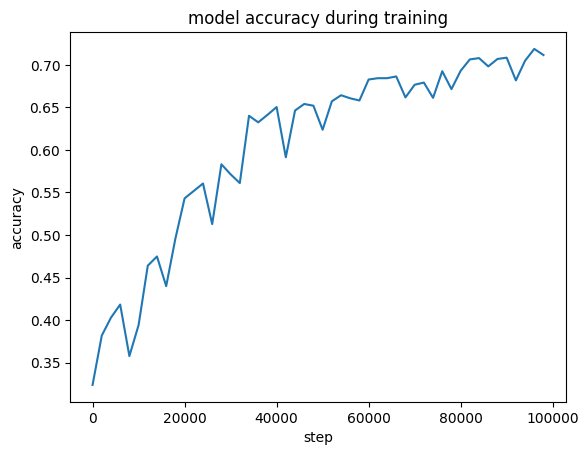

In [ ]:
loss_grad = jit(jax.grad(jit(loss))) # gradient

eta = 0.001 #learning rate
accuracies = [] #acc list that will be plotted

for step in range(50*2000):
    i = np.random.randint(len(train_images))
    img, lbl =train_images[i], train_labels[i]

    grads = loss_grad(p, img, lbl)

    p = Params(
        W1= p.W1- eta*grads.W1,
        b1= p.b1- eta*grads.b1,
        W2= p.W2 - eta*grads.W2,
        b2= p.b2 - eta*grads.b2
    )

    #checking every 2k steps the fraction of the test set that's correcrt
    if step % 2000 == 0:
        acc = jnp.mean(fractionCorrect(p,test_images,test_labels))
        print(step,acc)
        accuracies.append(acc)


plt.plot(range(0,50*2000,2000),accuracies)
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("model accuracy during training")
plt.show()


### e. Testing

By this point you should have a somewhat accurate classifier. 66% is not great for production work; you can do better by improving your training and the size of your network, but to keep the assignment reasonable we will stop there.

Now we would like to know how accurate we would expect our model to be on data it's never seen before. You can't use the data you trained on because your model has already seen it; we want to make sure that it's not just memorizing the data that it's already seen (this is sometimes referred to as overfitting). This is where the test data comes in. Use your `fractionCorrect` function to assess how good your model is on the test data set.

In [ ]:
testaccuracy = jnp.mean(fractionCorrect(p,test_images,test_labels))
print("test data accuracy:", testaccuracy)

test data accuracy: 0.68839836


Q: Did you overfit your model? Why or why not?

A: I didn't overfit the model since the testing data classification accuracy is similar to the training data classification accuracy and overfitting a model would lead to poor classification accuracy for unfamiliar test data. So, the model is actually learning.

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

**Acknowledgement:** This assignment is inspired by material and tutorials from <a href="https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/"> Galaxy Zoo</a>
* Bryan Clark and Ryan Levy (original)


Copyright: 2021

---